In [ ]:
from torch.utils.data import DataLoader,Dataset
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.models as models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_data = datasets.CIFAR10(root='./data',train=True,download=True,transform=torchvision.transforms.ToTensor())
test_data = datasets.CIFAR10(root='./data',train=False,download=True,transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_data,batch_size=64,shuffle=True)
test_loader = DataLoader(test_data,batch_size=64,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class VarAutoencoder(torch.nn.Module):
    def __init__(self):
        super(VarAutoencoder,self).__init__()
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(3072,128)
        self.fc2 = torch.nn.Linear(128,3072)
        self.mu = torch.nn.Linear(128,128)
        self.log_var = torch.nn.Linear(128,128)
        self.conv1 = torch.nn.Conv2d(3,16,5,padding=2)
        self.conv2 = torch.nn.Conv2d(16,3,5,padding=2)
        self.tconv1 = torch.nn.ConvTranspose2d(3,16,3,stride=1,padding=1)
        self.tconv2 = torch.nn.ConvTranspose2d(16,3,3,stride=1,padding=1)
        self.flatten = torch.nn.Flatten()
        self.unflatten = torch.nn.Unflatten(1,(3,32,32))

    def forward(self,x):
        x,mu,log_var = self.encode(x)
        x = self.reparameterize(mu,log_var)
        x = self.decode(x)
        return x,mu,log_var
    def encode(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        return x,mu,log_var
    def decode(self,x):
        x = self.fc2(x)
        x = self.relu(x)
        x = self.unflatten(x)
        x = self.tconv1(x)
        x = self.relu(x)
        x = self.tconv2(x)
        x = self.sigmoid(x)
        return x
    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

In [ ]:
model = VarAutoencoder().to(device)
epochs = 50
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = torch.nn.BCELoss(reduction='sum')

In [ ]:
for epoch in range(epochs):
    train_loss = 0.0
    for data in tqdm(train_loader):
        img,label = data
        img = img.to(device)
        output,mu,log_var = model(img)
        bce_loss = criterion(output,img)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = bce_loss + kld_loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('\n'+f'epoch: {epoch}, loss: {train_loss}')

100%|██████████| 782/782 [00:11<00:00, 69.37it/s]



epoch: 0, loss: 97983583.375


100%|██████████| 782/782 [00:09<00:00, 78.52it/s]



epoch: 1, loss: 95307267.0234375


100%|██████████| 782/782 [00:09<00:00, 78.22it/s]



epoch: 2, loss: 93992385.39453125


100%|██████████| 782/782 [00:10<00:00, 77.65it/s]



epoch: 3, loss: 93194891.95898438


100%|██████████| 782/782 [00:09<00:00, 83.63it/s]


epoch: 4, loss: 92813088.25585938


(64, 3, 32, 32)


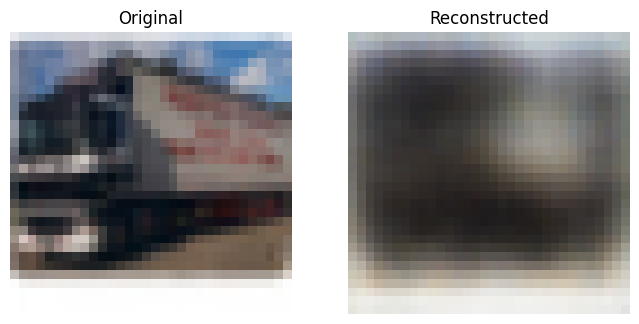

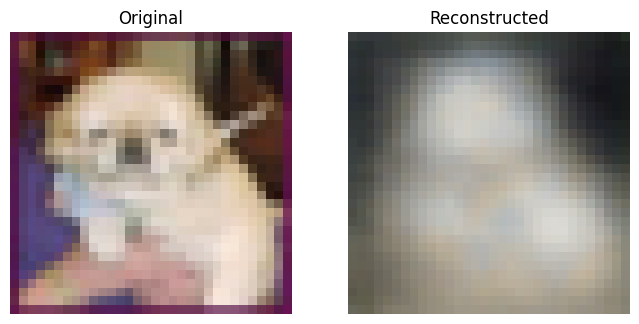

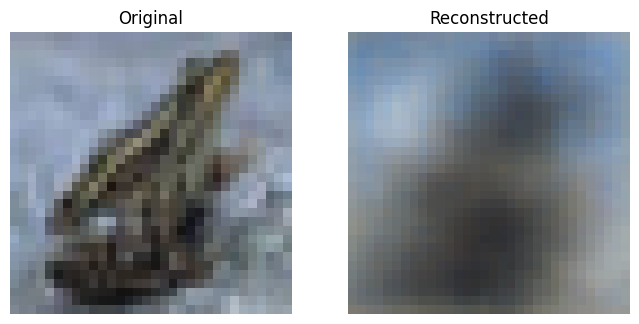

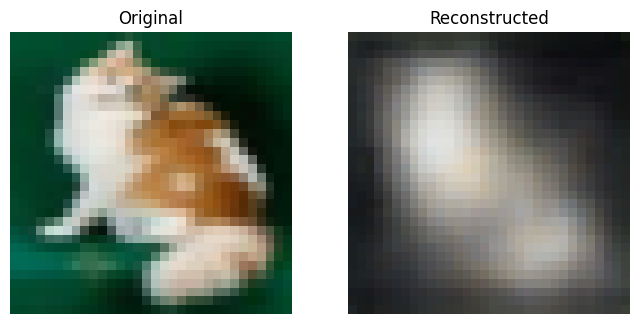

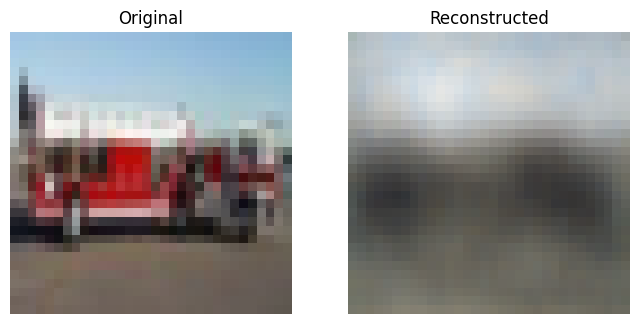

In [ ]:
data_iter = iter(train_loader)
images,labels = next(data_iter)

with torch.no_grad():
    output,mu,log_var = model(images.to(device))
    output = output.cpu()
    output = output.numpy()
    print(output.shape)
    output = np.reshape(output,(64,3,32,32))



for j in range(5):
    image = images[j]
    image = np.transpose(image,(1,2,0))
    output_im = output[j]
    output_im = np.transpose(output_im,(1,2,0))
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(image)
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(output_im)
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')
    plt.show()

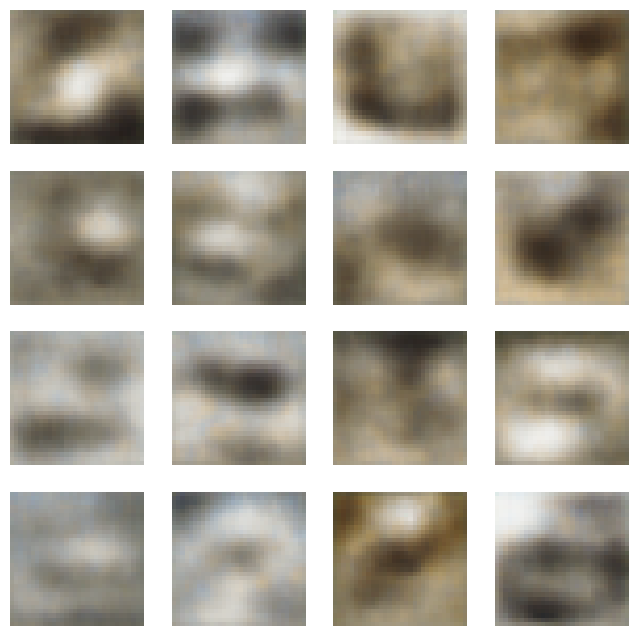

In [ ]:
with torch.no_grad():
    z = torch.randn(16, 128).to(device)
    samples = model.decode(z).cpu().view(-1,3,32,32)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].permute(1, 2, 0))
    ax.axis("off")
plt.show()
